# **<center>Imports</center>**

In [21]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers.merging import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [22]:
train_data_path = "photos/train/"
test_data_path = "photos/test/"

In [23]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(train_data_path, target_size=(256,256), batch_size=15, class_mode=None)

Found 1500 images belonging to 1 classes.


In [24]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(test_data_path, target_size=(256, 256), batch_size=15, class_mode=None)

Found 1500 images belonging to 1 classes.


In [25]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [26]:
X_train,y_train = prepareInputData(train_data_path + "train_data/", 256, 256)
X_test, y_test = prepareInputData(test_data_path + "test_data/", 256, 256)

In [27]:
X_train[0]

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)

In [28]:
y_train[6]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

# **<center>Making the Model</center>**

In [29]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [30]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModel(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_8/FusedBatchNormV3:0', description="created by layer 'batch_normalization_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_11/FusedBatchNormV3:0', description="created by layer 'batch_normalization_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [32]:
ALPHA = 0.5
BETA = 0.5

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [33]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [34]:
LEARNING_RATE = 0.01
model.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss="mse", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 256, 256, 16  0           ['conv2d_8[0][0]']               
                                )                                                           

In [35]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit_generator(GenerateInputs(X_train,y_train),epochs=5,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=50)

Epoch 1/5
5/5 [==============================] - 33s 7s/step - loss: 0.2962 - acc: 0.6243 - val_loss: 1.0000 - val_acc: 0.9965
Epoch 2/5
5/5 [==============================] - 23s 5s/step - loss: 0.2065 - acc: 0.3417 - val_loss: 1.0000 - val_acc: 1.0000
Epoch 3/5
5/5 [==============================] - 21s 5s/step - loss: 0.1455 - acc: 0.6185 - val_loss: 1.0000 - val_acc: 1.0000
Epoch 4/5
5/5 [==============================] - 22s 5s/step - loss: 0.1719 - acc: 0.3222 - val_loss: 1.0000 - val_acc: 1.0000
Epoch 5/5
5/5 [==============================] - 25s 6s/step - loss: 0.0528 - acc: 0.9647 - val_loss: 1.0000 - val_acc: 1.0000


In [36]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [37]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

# **<center>Testing the Model</center>**

In [38]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [39]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = model.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 481ms/step
Prediction made
reshaped


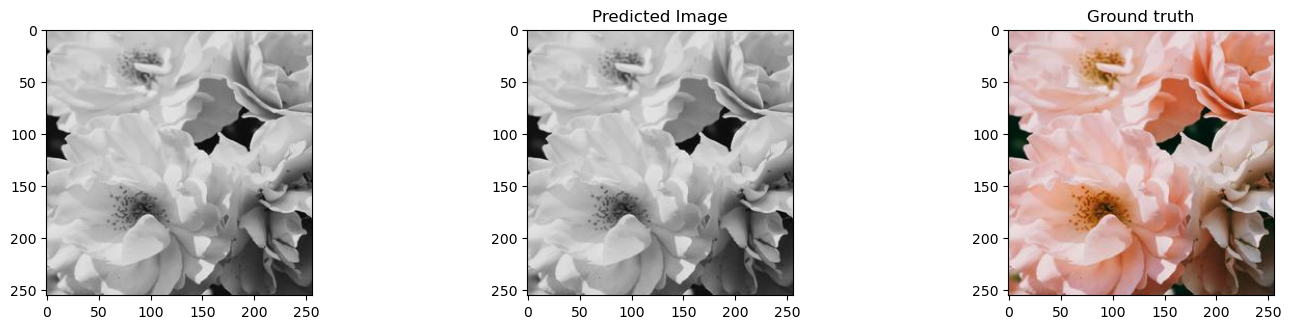

In [40]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)